Here, we examine functional sensitivity of the structure model on a small simulated dataset

In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 100
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Text(0.5, 0, 'individual')

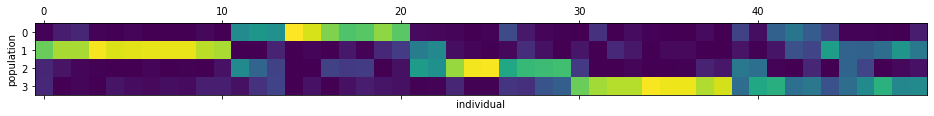

In [5]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

In [6]:
g_obs.shape

(50, 100, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


In [8]:
print(prior_params_dict)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [9]:
k_approx = 12

In [10]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [11]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (100, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (50, 11) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (50, 11) (lb=0.0001, ub=inf)


## Initialize 

In [13]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 412)

In [15]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

Text(0.5, 0, 'individual')

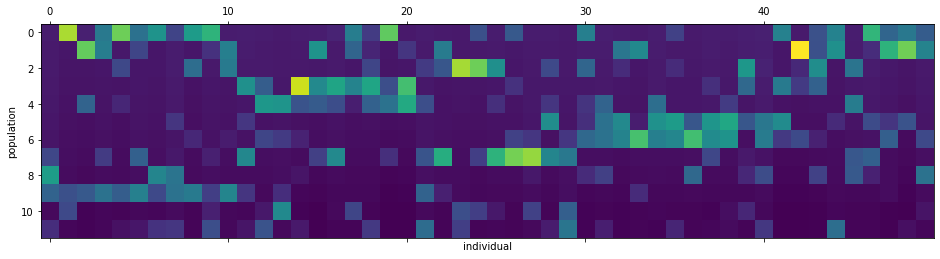

In [16]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())
plt.ylabel('population')
plt.xlabel('individual')

# Run CAVI

In [17]:
# get beta parameters for sticks and populations
vb_opt_dict, vb_opt, ez_opt, _, _ = \
    cavi_lib.run_cavi(g_obs, vb_params_dict, 
                        vb_params_paragami, 
                        prior_params_dict,
                        gh_loc = gh_loc, gh_weights = gh_weights,
                        max_iter = 1000,
                        x_tol = 1e-3, 
                        print_every = 20)


CAVI compile time: 2.8sec

 running CAVI ...
iteration [20]; kl:8200.201224; elapsed: 0.4188secs
iteration [40]; kl:7977.817008; elapsed: 0.3157secs
iteration [60]; kl:7823.383367; elapsed: 0.2702secs
iteration [80]; kl:7788.260412; elapsed: 0.2879secs
iteration [100]; kl:7756.791973; elapsed: 0.2923secs
iteration [120]; kl:7750.510824; elapsed: 0.2762secs
iteration [140]; kl:7745.703836; elapsed: 0.2908secs
iteration [160]; kl:7728.543424; elapsed: 0.3145secs
iteration [180]; kl:7704.637801; elapsed: 0.2858secs
iteration [200]; kl:7678.660644; elapsed: 0.3209secs
iteration [220]; kl:7614.152068; elapsed: 0.3037secs
iteration [240]; kl:7552.157314; elapsed: 0.2644secs
iteration [260]; kl:7551.820115; elapsed: 0.2604secs
iteration [280]; kl:7551.807349; elapsed: 0.2718secs
CAVI done.
Elapsed: 289 steps in 4.29 seconds


# Check out the fit

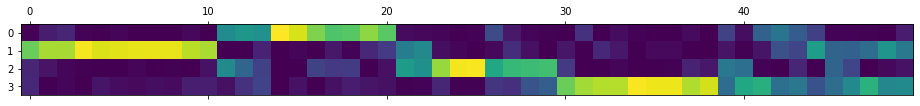

In [18]:
# truth
plt.matshow(true_ind_admix_propn.T)

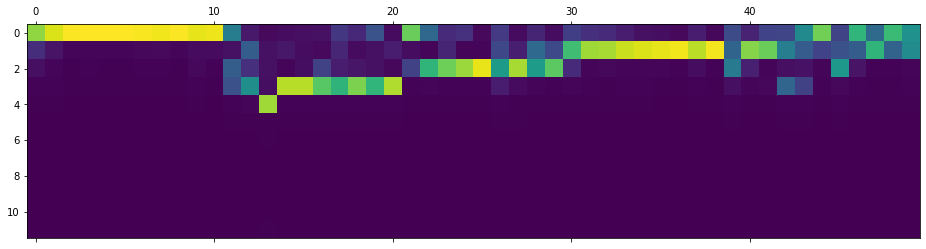

In [19]:
# fitted
e_ind_admix = get_vb_expectations(vb_opt_dict, use_logitnormal_sticks)[0]
plt.matshow(e_ind_admix.T)

# Define prior perturbation

In [20]:
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

In [21]:
def log_phi(logit_v):
    return(sp.special.expit(-logit_v))

def phi(logit_v):
    return np.exp(log_phi(logit_v))


In [22]:
logit_v_grid = np.linspace(-8, 8, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))
log_phi_max = np.max(np.abs(np.log(phi(logit_v_grid))))
print('log phi max: ', log_phi_max)

def rescaled_log_phi(logit_v):
    return 2 * log_phi(logit_v) / log_phi_max


phi max:  2.717370405124736
log phi max:  0.9996646498695336


In [23]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['dp_prior_alpha'],
                                log_phi = rescaled_log_phi, 
                                logit_v_ub=8, logit_v_lb = -8)

print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)


-1.0986122886681098 1.5674499614238597 -1.0996184973479006 1.5669044626347488


Text(0.5, 1.0, 'Priors in logit space')

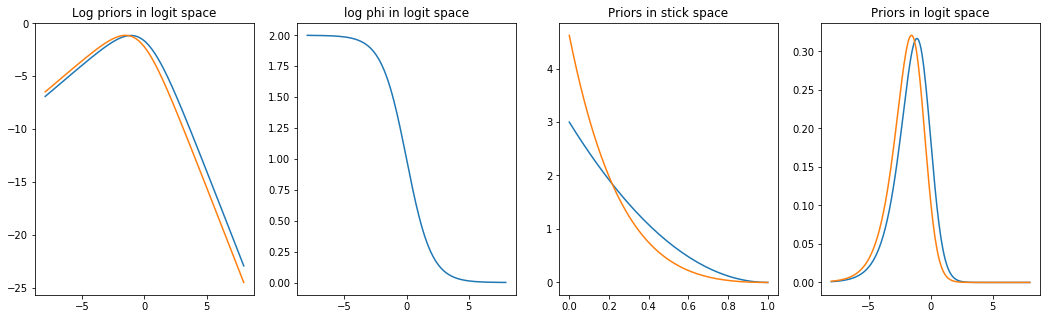

In [24]:
prior_perturbation.set_epsilon(1.0)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [25]:
log_prior_pert = lambda logit_v : rescaled_log_phi(logit_v) - prior_perturbation.log_norm_pc_logit

In [26]:
prior_perturbation.log_norm_pc_logit

DeviceArray(1.56690446, dtype=float64)

In [28]:
# we will use theses for the sensitivity class
get_epsilon_vb_loss = paragami.FlattenFunctionInput(
    lambda params, epsilon: structure_model_lib.get_kl(
                                                        g_obs, 
                                                        params,
                                                        prior_params_dict,
                                                        epsilon = epsilon,
                                                        gh_loc = gh_loc,
                                                        gh_weights = gh_weights,
                                                        log_phi = log_prior_pert,
                                                        ),
    argnums=0, patterns=vb_params_paragami, free=True)
    
def get_e_log_perturbation(log_phi, vb_params_dict, epsilon, gh_loc, gh_weights): 
    return func_sens_lib.get_e_log_perturbation(log_phi,
                            vb_params_dict['ind_mix_stick_propn_mean'],
                            vb_params_dict['ind_mix_stick_propn_info'],
                            epsilon, gh_loc, gh_weights, sum_vector=True)


hyper_par_objective_fun = paragami.FlattenFunctionInput(
    lambda params, epsilon: get_e_log_perturbation(log_prior_pert, 
                                                    params,
                                                    epsilon,
                                                    gh_loc, gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)

In [29]:
epsilon0 = np.array([0.])

In [30]:
t0 = time.time()
mfvb_preconditioner = \
    get_mfvb_cov(vb_opt_dict, vb_params_paragami, use_logitnormal_sticks, return_info = True)

print('preconditioner time: {:0.3}sec'.format(time.time() - t0))

preconditioner time: 0.435sec


In [31]:
import vittles

In [32]:
# get hessian-vector product
def get_jac_hvp_fun(f):
    def hvp(x, v):
        return jax.jvp(jax.grad(f), (x, ), (v, ))[1]
    return hvp

In [35]:
obj_fun_hvp = jax.jit(get_jac_hvp_fun(lambda x : get_epsilon_vb_loss(x, epsilon0)))

In [36]:
cg_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, x), 
                                            dim = len(vb_opt), 
                                            cg_opts = {'M': mfvb_preconditioner})


In [42]:
epsilon_sens = HyperparameterSensitivityLinearApproximation(get_epsilon_vb_loss,
                                                        vb_opt,
                                                        epsilon0, 
                                                        hyper_par_objective_fun = hyper_par_objective_fun,
                                                        hess_solver = cg_solver)


Compiling objective function derivatives ... 
Compile time: 0.158sec

Objective function derivative time: 0.000153sec

Linear system compile time: 1.42sec
Linear system time: 1.35sec


# Fit with perturbation

In [43]:
epsilon = 1.0
print('Epsilon: ', epsilon)

lr_vb_free_params = epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

print('Predicted differences: ', np.linalg.norm(lr_vb_free_params - vb_opt))

Epsilon:  1.0
Predicted differences:  12.622706298840754


In [44]:
vb_pert_pred_dict = vb_params_paragami.fold(lr_vb_free_params, free = True)

In [45]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [47]:
vb_pert_dict, vb_opt_pert, e_z_pert, _, _ = \
    cavi_lib.run_cavi(g_obs, deepcopy(new_init_dict), 
                        vb_params_paragami, 
                        prior_params_dict,
                        gh_loc = gh_loc, gh_weights = gh_weights,
                        max_iter = 1000,
                        x_tol = 1e-3, 
                        print_every = 20, 
                        epsilon = epsilon, log_phi = log_prior_pert)


CAVI compile time: 2.08sec

 running CAVI ...
iteration [20]; kl:7632.566749; elapsed: 0.2965secs
iteration [40]; kl:7631.90689; elapsed: 0.3592secs
iteration [60]; kl:7631.753456; elapsed: 0.2995secs
iteration [80]; kl:7631.656945; elapsed: 0.2857secs
iteration [100]; kl:7631.586762; elapsed: 0.2868secs
iteration [120]; kl:7631.559159; elapsed: 0.2859secs
iteration [140]; kl:7631.552836; elapsed: 0.2869secs
CAVI done.
Elapsed: 152 steps in 2.27 seconds


In [48]:
np.linalg.norm(vb_opt_pert - vb_opt)

DeviceArray(12.43982527, dtype=float64)

### compare

In [49]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot((lr_vb_free_params - vb_opt), 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


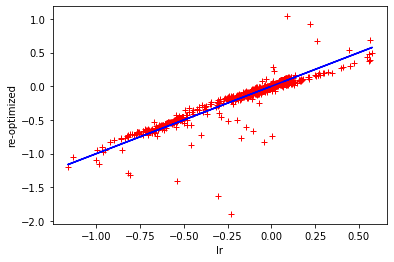

In [50]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [51]:
# compare expectations
init_e_ind_admix, init_e_pop_freq = get_vb_expectations(vb_opt_dict, use_logitnormal_sticks)
pert_e_ind_admix, pert_e_pop_freq = get_vb_expectations(vb_pert_dict, use_logitnormal_sticks)
lr_e_ind_admix, lr_e_pop_freq = get_vb_expectations(vb_params_paragami.fold(lr_vb_free_params, free = True), 
                                                    use_logitnormal_sticks)

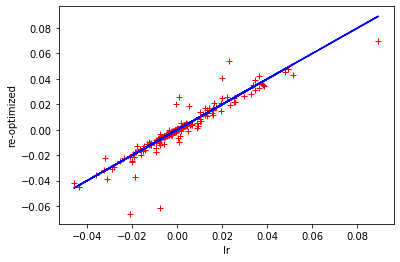

In [52]:
print_diff_plot(lr_e_ind_admix, pert_e_ind_admix, init_e_ind_admix)

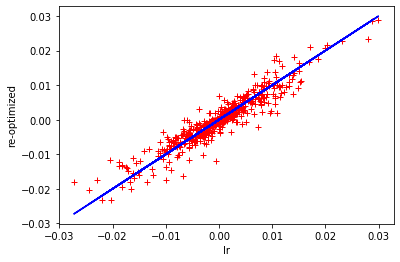

In [53]:
print_diff_plot(lr_e_pop_freq, pert_e_pop_freq, init_e_pop_freq)

In [54]:
print('init number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(init_e_ind_admix))

print('pert number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix))
print('lr number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix))

init number of cluster:  5.57758842028215
pert number of cluster:  5.761535141874984
lr number of cluster:  5.7084832217153965


# Fit for a range of epsilon

In [55]:
epsilon_list = np.linspace(0, 1, 8) ** 2 # Square to get more points close to 0
print(epsilon_list)

[0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [59]:
def refit_with_epsilon(epsilon, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    vb_opt_pert = \
        cavi_lib.run_cavi(g_obs, deepcopy(new_init_dict), 
                            vb_params_paragami, 
                            prior_params_dict,
                            gh_loc = gh_loc, gh_weights = gh_weights,
                            max_iter = 1000,
                            x_tol = 1e-3, 
                            print_every = 20, 
                            epsilon = epsilon, log_phi = log_prior_pert)[1]

        
    return vb_opt_pert


In [60]:
print('epsilons: ', epsilon_list)

epsilons:  [0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [61]:
vb_pert_list = []
for epsilon in epsilon_list: 
    print('\n re-optimzing with epsilon = ', epsilon)
    
    vb_pert_list.append(refit_with_epsilon(epsilon, new_init_dict))



 re-optimzing with epsilon =  0.0
CAVI compile time: 2.15sec

 running CAVI ...
CAVI done.
Elapsed: 4 steps in 0.06 seconds

 re-optimzing with epsilon =  0.02040816326530612
CAVI compile time: 2.03sec

 running CAVI ...
iteration [20]; kl:7554.182197; elapsed: 0.296secs
CAVI done.
Elapsed: 24 steps in 0.35 seconds

 re-optimzing with epsilon =  0.08163265306122448
CAVI compile time: 2.1sec

 running CAVI ...
iteration [20]; kl:7561.116852; elapsed: 0.3076secs
CAVI done.
Elapsed: 35 steps in 0.54 seconds

 re-optimzing with epsilon =  0.18367346938775508
CAVI compile time: 2.14sec

 running CAVI ...
iteration [20]; kl:7572.027885; elapsed: 0.4768secs
iteration [40]; kl:7571.999354; elapsed: 0.4348secs
CAVI done.
Elapsed: 50 steps in 1.11 seconds

 re-optimzing with epsilon =  0.32653061224489793
CAVI compile time: 2.43sec

 running CAVI ...
iteration [20]; kl:7585.977332; elapsed: 0.354secs
iteration [40]; kl:7585.891555; elapsed: 0.4322secs
iteration [60]; kl:7585.879586; elapsed: 0.

# Check free parameters

In [62]:
lr_list = []

for epsilon in epsilon_list: 
    
    # get linear response
    lr_list.append(epsilon_sens.predict_opt_par_from_hyper_par(epsilon))


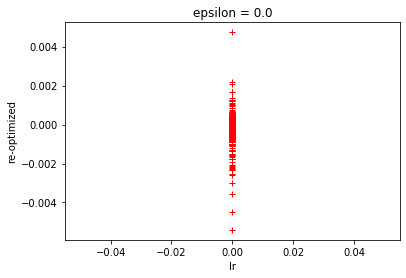

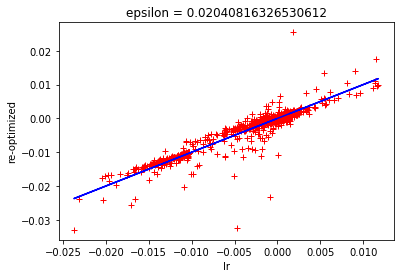

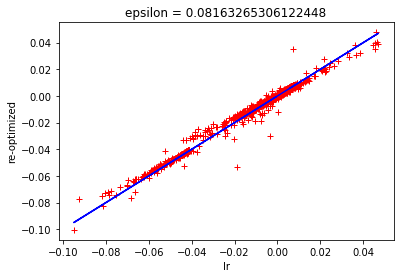

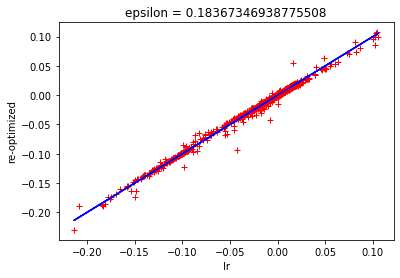

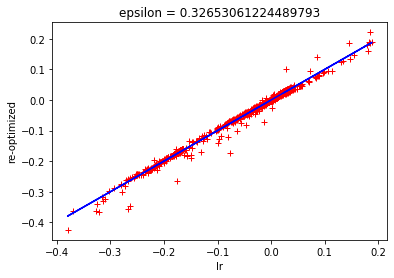

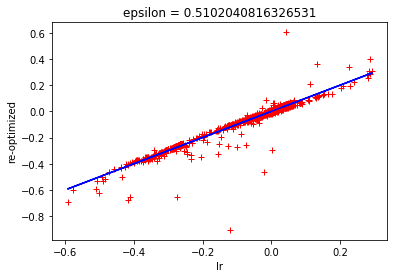

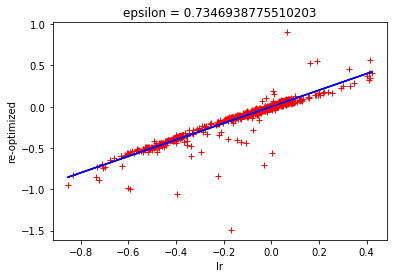

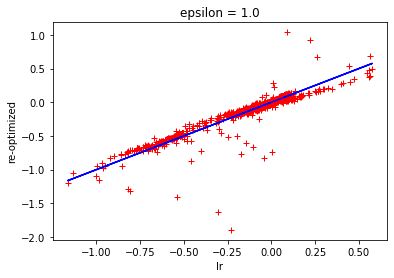

In [63]:
for i in range(len(epsilon_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('epsilon = {}'.format(epsilon_list[i]))


# Number of clusters

In [65]:
lr_e_num_clusters_vec = onp.zeros(len(epsilon_list))
refit_e_num_clusters_vec = onp.zeros(len(epsilon_list))

for i in range(len(epsilon_list)): 
    
    # get dictionaries
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    
    # get posterior expectations
    pert_e_ind_admix, pert_e_pop_freq = get_vb_expectations(pert_dict, use_logitnormal_sticks)
    lr_e_ind_admix, lr_e_pop_freq = get_vb_expectations(lr_dict, use_logitnormal_sticks)
    
    # get number of clusters
    refit_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix)
    lr_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)


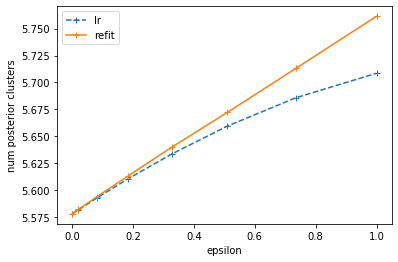

In [66]:
plt.plot(epsilon_list, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('epsilon')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))
